# SHO Fitting in Pytorch

In [1]:
import sys
sys.path.append('../../')
sys.path.append('/home/ferroelectric/m3_learning/m3_learning/src')

In [2]:
%load_ext autoreload

import os
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

from m3_learning.optimizers.AdaHessian import AdaHessian
from m3_learning.nn.SHO_fitter.SHO import SHO_fit_func_torch
from m3_learning.be.processing import convert_amp_phase, SHO_fit_to_array
from m3_learning.util.preprocessing import global_scaler
from m3_learning.nn.random import random_seed
from m3_learning.nn.benchmarks.inference import computeTime
from m3_learning.util.file_IO import make_folder
from m3_learning.be.dataset import BE_Dataset
from m3_learning.be.nn import SHO_Model, SHO_NN_Model
from m3_learning.viz.style import set_style

set_style("printing")

2023-04-02 16:23:23.294017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 16:23:23.410581: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-02 16:23:23.848921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-02 16:23:23.848974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

printing set for seaborn


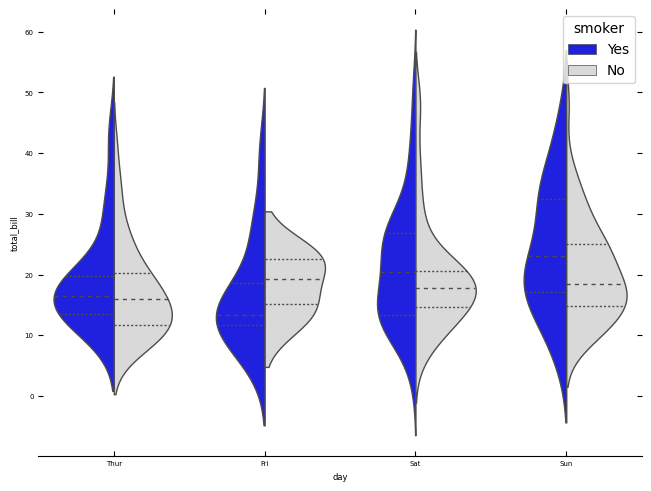

In [15]:
import seaborn as sns
# sns.set_theme(style="whitegrid")

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=tips, x="day", y="total_bill", hue="smoker",
               split=True, inner="quart", linewidth=1,
               palette={"Yes": "b", "No": ".85"})
sns.despine(left=True)

plt.show()


In [16]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## Loads Data

In [5]:
# Sets path to file
path = r"./"

# instantiate the dataset object
dataset = BE_Dataset("./data_file_raw.h5", testing=True)

# print the contents of the file
dataset.print_be_tree()

# sets size for resampling
dataset.resample_bins = 80

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
    ├ complex
      -------
      ├ imag
      ├ imag_resampled
      ├ imag_resampled_scaled
      ├ real
      ├ real_resampled
      ├ real_resampled_scaled
    ├ magnitude_spectrum


## Testing the Torch Function

The function for a simple-harmonic oscillator needs to be recast in PyTorch. Here we prove that the PyTorch function is implemented identically to the Numpy model. 

Note: This uses the results from the least squares fitting LSQF results. 

printing set for seaborn
spectra number 603


/home/ferroelectric/m3_learning/m3_learning/src/m3_learning/be/dataset.py:1002: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


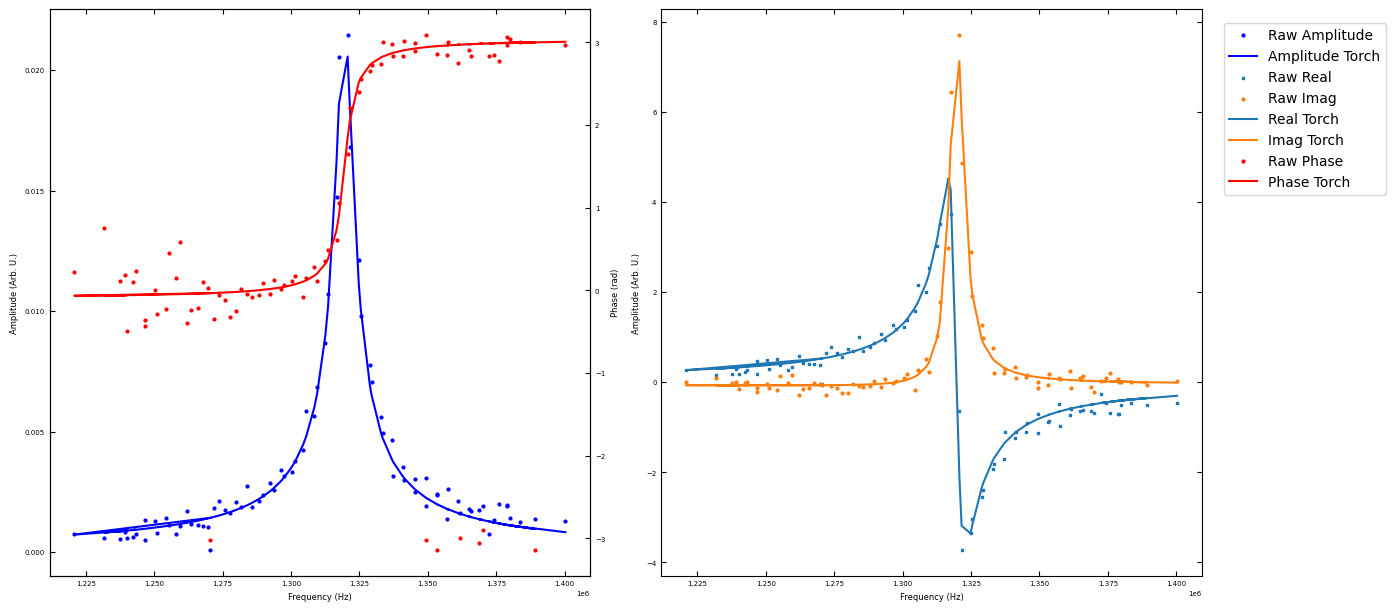

In [6]:
_ = dataset.complex_spectrum_real_resampled_scaled
_ = dataset.complex_spectrum_imag_resampled_scaled

#TODO fix the style setter
set_style("printing")
dataset.LSQF_torch_function_comparison()
plt.show()

## Pytorch Model

### Model Architecture

![](Assets\Figures\model_architecture_sho.png)

### Builds the Model

In [7]:
SHO_nn = SHO_Model(dataset)

### Test/Train Split

In [8]:
# builds the test train split for the data
data_train, data_test, params_train, params_test = train_test_split(
    dataset.nn_raw_input, dataset.SHO_params_scaled, test_size=0.7, random_state=42
)

# conduct the inverse transform to get the original data
params_test_unscaled = dataset.nn_parms_scalar.inverse_transform(params_test)


### Training

In [9]:
# sets the model and DataType
model = SHO_nn.cuda().double()

# views the structure of the model
print(model)

SHO_Model(
  (hidden_x1): Sequential(
    (0): Conv1d(2, 8, kernel_size=(7,), stride=(1,))
    (1): SELU()
    (2): Conv1d(8, 6, kernel_size=(7,), stride=(1,))
    (3): SELU()
    (4): Conv1d(6, 4, kernel_size=(5,), stride=(1,))
    (5): SELU()
  )
  (hidden_xfc): Sequential(
    (0): Linear(in_features=256, out_features=20, bias=True)
    (1): SELU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): SELU()
  )
  (hidden_x2): Sequential(
    (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv1d(2, 4, kernel_size=(5,), stride=(1,))
    (2): SELU()
    (3): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (4): SELU()
    (5): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (6): SELU()
    (7): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (8): SELU()
    (9): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (10): SELU()
    (11): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (12): SELU()
    (13): AvgPool1d(kernel_size=(2,), 

In [10]:
make_folder(f"{path}Trained Models/SHO Fitter/")

nn_ = SHO_NN_Model(model)

nn_.train(data_train, 200)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


/home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/torch/autograd/__init__.py:204: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1146.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch : 1/5, recon loss = 0.08006797
--- 17.49965739250183 seconds ---
epoch : 2/5, recon loss = 0.04324457
--- 15.63521695137024 seconds ---
epoch : 3/5, recon loss = 0.04281088
--- 15.899449110031128 seconds ---
epoch : 4/5, recon loss = 0.04258437
--- 16.21093440055847 seconds ---
epoch : 5/5, recon loss = 0.04246209
--- 16.34120774269104 seconds ---


### Calculate Inference Time

In [11]:
nn_.inference_calculator(data_train)


Avg execution time (ms): 0.007055


### Validation Reconstruction

In [12]:
nn_.predict(data_test, validation=True)

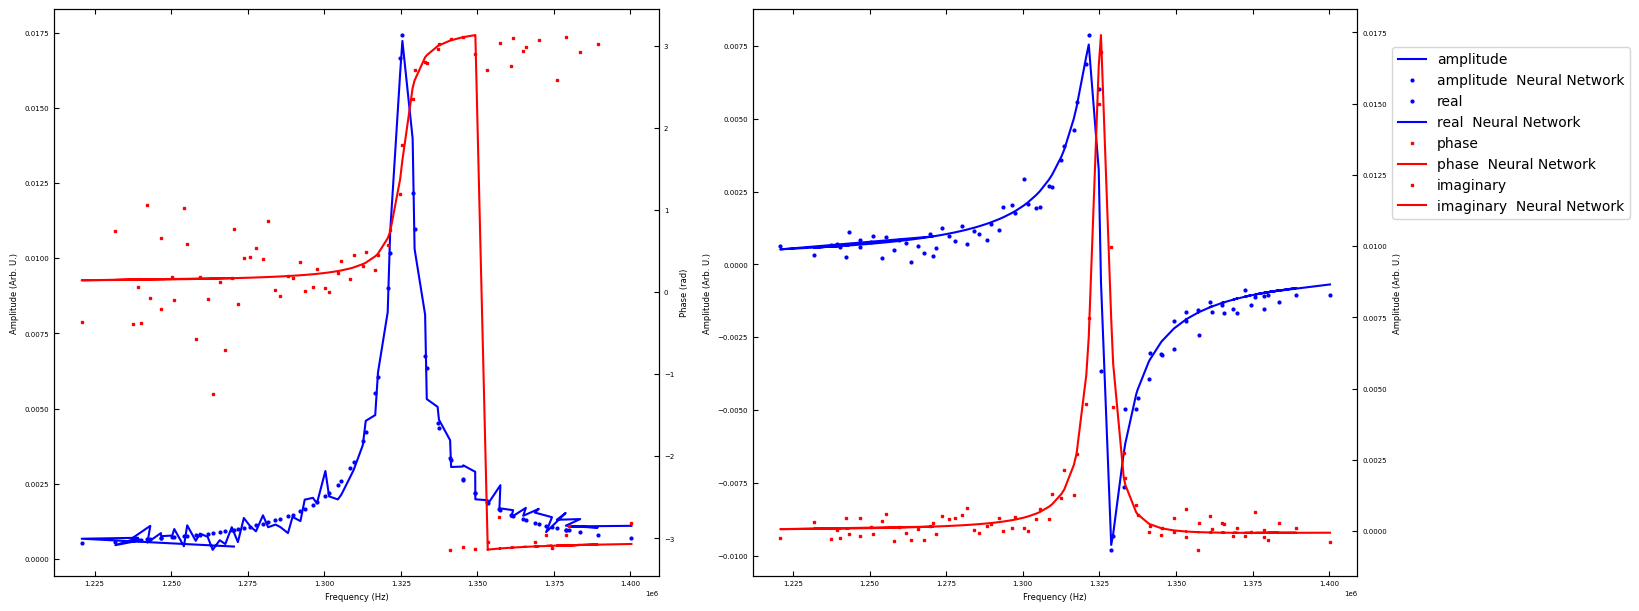

In [13]:
i = np.random.randint(0, dataset.nn_validation.shape[0])

original = nn_.unscale_complex(data_test[[i],:])[0]
predicted = nn_.unscale_complex(dataset.nn_validation[[i], :])[0]

dataset.lsqf_viz.raw_data(original, predicted, predict_label='Neural Network')

MSE for real component: 0.04380559176206589
MSE for imaginary component: 0.04215747117996216
Average MSE: 0.04298153147101402


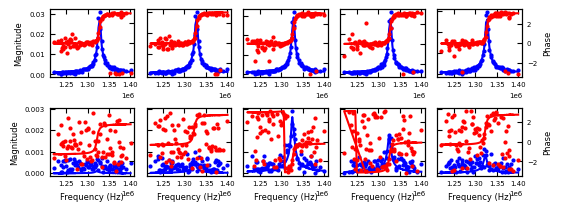

In [14]:
nn_.best_and_worst(data_test, dataset.nn_validation)
plt.show()

In [ ]:
import pandas as pd
self = nn_

def to_df(self, data, params):
    df_to_plot = 
 

In [42]:
import pandas as pd

df = pd.DataFrame()

true = params_test
compare = dataset.nn_validation_params_scaled

names = [true, compare]
names_str = ['SHO', 'NN']
labels = ['Amplitude', 'Resonance', 'Q-Factor', 'Phase']

for j, name in enumerate(names):
    for i, label in enumerate(labels):
        dict_ = {"value": name[:,i],
                 "parameter": np.repeat(label, name.shape[0]),
                 "dataset": np.repeat(names_str[j], name.shape[0])}
        
        df = pd.concat((df, pd.DataFrame(dict_)))


<Axes: xlabel='parameter', ylabel='value'>

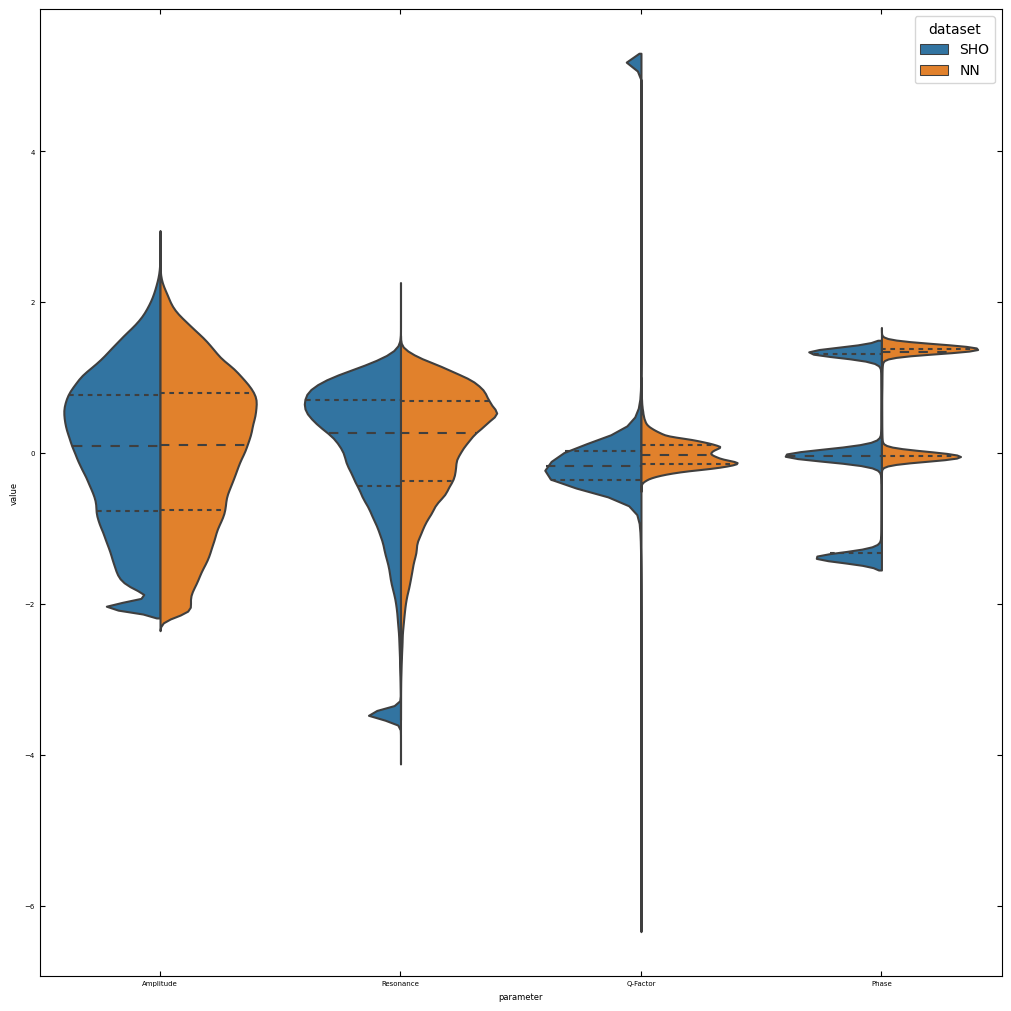

In [56]:
df.head()
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=True)

sns.violinplot(x='parameter', y='value', hue='dataset',
               data=df, ax=axs, scale='count', split=True, inner='quartile')


In [ ]:
df_to_plot = pd.DataFrame(np.vstack((all_pred_params_scaled, scaled_params)))
df_to_plot = df_to_plot.melt(var_name='Params', value_name='Normalized Params')
df_to_plot['Fit Type'] = 'LSQF'

for i in range(0, 8, 2):
  df_to_plot.loc[i*all_pred_params_scaled.shape[0]
    :(i+1)*all_pred_params_scaled.shape[0], 'Fit Type'] = 'NN'


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=True)

labels = ['Amplitude', 'Resonance', 'Q-Factor', 'Phase']

sns.violinplot(x='Params', y='Normalized Params', hue='Fit Type',
               data=df_to_plot, ax=axs, scale='count', split=True, inner='quartile')
axs.set_xticklabels(labels)
sns.set_theme(style='whitegrid')

printing.savefig(fig, f"Figure_15_SHO_fit_Violin.png")
